In [4]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage.io import imread_collection, ImageCollection
from skimage import transform
from skimage import img_as_int
from skimage import data
from skimage.transform import swirl
import skimage as skimage
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
import alpenglow.stitching2 as ast2
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack
from alpenglow.stitching2 import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack

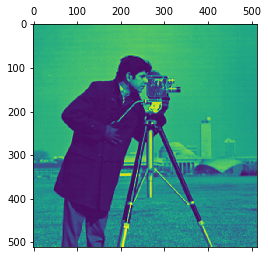

In [5]:
camera = data.camera()
plt.matshow(camera)

In [3]:
image1 = camera[50:200]
image2 = camera[150:300]
image3 = camera[250:400]

In [4]:
image1 = np.pad(image1, ((0,0),(0,38)), 'constant', constant_values=(0))
image2 = np.pad(image2, ((0,0),(38,0)), 'constant', constant_values=(0))
image3 = np.pad(image3, ((0,0),(19,19)), 'constant', constant_values=(0))

#### Now making a two-color camera

In [6]:
camera_invert = skimage.util.invert(camera)

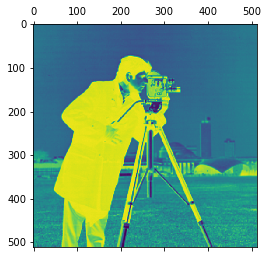

In [7]:
plt.matshow(camera_invert)

#### Combining into a two channel image

In [7]:
image1_invert = camera_invert[50:200]
image2_invert = camera_invert[150:300]
image3_invert = camera_invert[250:400]

In [8]:
image1 = camera[50:200]
image2 = camera[150:300]
image3 = camera[250:400]

In [9]:
camera_2chan_image1 = np.vstack((image1, image1_invert))
camera_2chan_image2 = np.vstack((image2, image2_invert))
camera_2chan_image3 = np.vstack((image3, image3_invert))

In [10]:
camera_2chan_image1 = np.pad(camera_2chan_image1, ((0,0),(0,38)), 'constant', constant_values=(0))
camera_2chan_image2 = np.pad(camera_2chan_image2, ((0,0),(38,0)), 'constant', constant_values=(0))
camera_2chan_image3 = np.pad(camera_2chan_image3, ((0,0),(19,19)), 'constant', constant_values=(0))

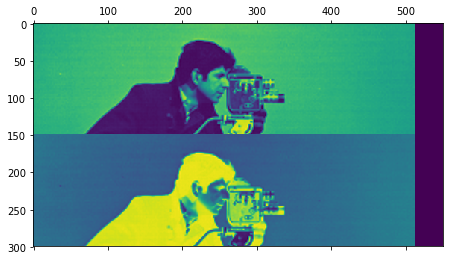

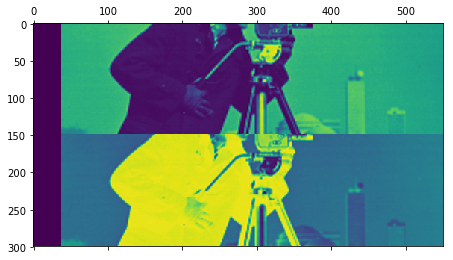

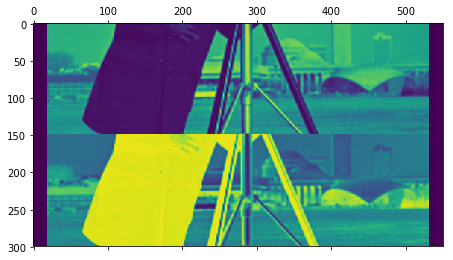

In [11]:
plt.matshow(camera_2chan_image1)
plt.matshow(camera_2chan_image2)
plt.matshow(camera_2chan_image3)

### Playing with apply_shift

In [12]:
translation = skimage.feature.register_translation(image2, image1)
translation = translation[0]
translation

array([ 50.,   0.])

In [13]:
shift = test_apply_shift(image2, image1, translation, margin=30)

NameError: name 'test_apply_shift' is not defined

In [14]:
plt.matshow(shift[100:250],)
plt.matshow(image3)

NameError: name 'shift' is not defined

In [15]:
image3.shape

(150, 512)

In [16]:
translation = skimage.feature.register_translation(image3, shift[100:250,])
translation = translation[0]
translation

NameError: name 'shift' is not defined

In [17]:
all_three = test_apply_shift(image3, shift, translation, margin=30)

NameError: name 'test_apply_shift' is not defined

In [18]:
plt.matshow(all_three)
all_three.shape

NameError: name 'all_three' is not defined

In [19]:
def test_apply_shift(image1, image2, shift, margin=30):
    """ 
    Apply a lateral shift between two images, stitching them together
    
    Parameters
    ----------
    image1, image2 : 2D arrays
        The images to be stitched, *in order* (bottom, top)
    
    shift : sequence of length 2 
        x, y lateral shifts
    
    Returns
    -------
    Stitched image
    
    """
    cols1 = image1.shape[1]
    cols2 = image2.shape[1]
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]

    overlap = int(abs(shift[0]))
    registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
    registered[:rows2-margin] = image2[:rows2-margin]
    if shift[1] >= 0:
        registered[rows2-margin:, :cols1-int(shift[1])] = image1[overlap-margin:, int(shift[1]):] 
    else:
        registered[rows2-margin:, abs(int(shift[1])):] = image1[overlap-margin:, :int(shift[1])] 
    
    if margin > 0:
        fade2 = image2[rows2 - margin:rows2] * np.arange(1, 0, -(1/margin))[:, np.newaxis]
        fade1 = np.zeros_like(fade2)
        if shift[1] >= 0:
            fade1[:, :cols1-int(shift[1])] = (image1[overlap-margin:overlap, int(shift[1]):] * 
                                              np.arange(0, 1, (1/margin))[:, np.newaxis])
        else:
            fade1[:, abs(int(shift[1])):] = image1[overlap-margin:overlap, :int(shift[1])] * np.arange(0, 1, (1/margin))[:, np.newaxis]

        registered[rows2 - margin:rows2] = fade1 + fade2

    return registered.astype(int)

#### The problem was with overlap, switched to abs(shift[0])

### Now we have to fix find_shift

In [20]:
shift = ast2.find_shift(image2, image1)
shift

array([ 50.,   0.])

In [21]:
translation = skimage.feature.register_translation(image2[0:150,:], image1[0:150,:])
translation

(array([ 50.,   0.]), 0.49365498026746157, 5.3870519326481165e-17)

#### Problem is that a subsample of the image leads to poor registration in wide dimension

In [22]:
mosaic_12 = ast2.stitch(image2, image1, margin=30)
mosaic_12 = mosaic_12[0]

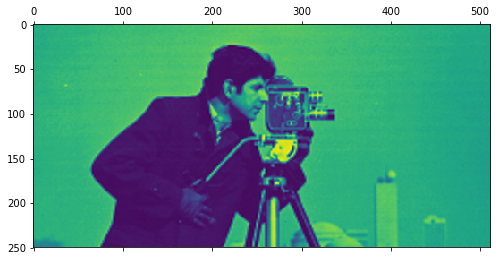

In [23]:
plt.matshow(mosaic_12)

In [24]:
mosaic_123 = ast2.stitch(image3, mosaic_12, margin=30)
mosaic_123 = mosaic_123[0]

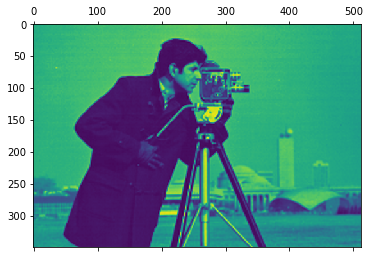

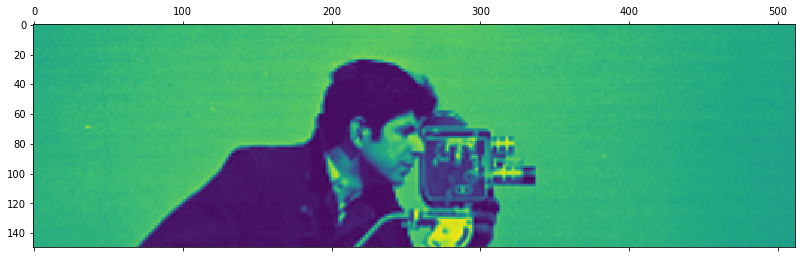

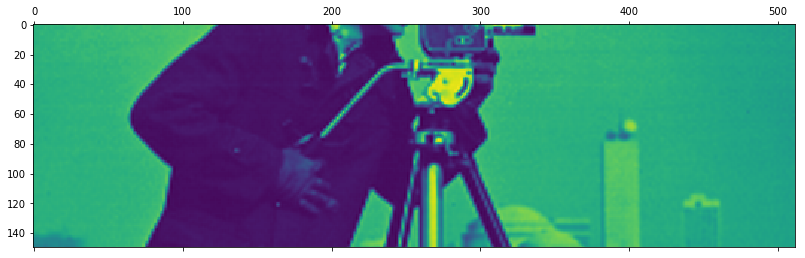

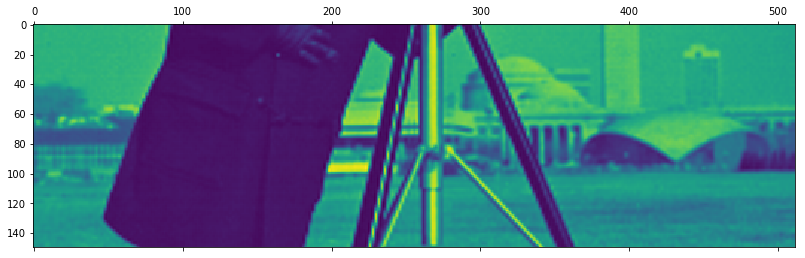

In [25]:
plt.matshow(mosaic_123)
plt.matshow(image1)
plt.matshow(image2)
plt.matshow(image3)

#### Great success! Stitching2 has effective find_shift, apply_shift, and stitch functions

### Creating z-stack, blurry images with depth

In [12]:
#creates 10 images in z-stack, crisp to blurry with increasing n
intervals = np.linspace(0.0,3.0,num=10)
for z in range(1,11):
    for number in intervals:
        image = (skimage.filters.gaussian(camera, number)*255).astype('uint8')
        strip1 = image[50:200]
        strip2 = image[150:300]
        strip3 = image[250:400]                    
        strip1 = np.pad(strip1, ((0,0),(0,38)), 'constant', constant_values=(0))
        strip2 = np.pad(strip2, ((0,0),(38,0)), 'constant', constant_values=(0))
        strip3 = np.pad(strip3, ((0,0),(19,19)), 'constant', constant_values=(0))
        z = int(number*3+1) 
        tiff.imsave("camera_strip1_z%01d.tif" % z , strip1)
        tiff.imsave("camera_strip2_z%01d.tif" % z , strip2)
        tiff.imsave("camera_strip3_z%01d.tif" % z , strip3)

In [13]:
images1= imread_collection("../notebooks/camera_strip1_z*")
images2= imread_collection("../notebooks/camera_strip2_z*")
images3= imread_collection("../notebooks/camera_strip3_z*")

In [47]:
from imp import reload

In [48]:
reload(ast2)

<module 'alpenglow.stitching2' from '../alpenglow/stitching2.py'>

In [16]:
mosaic_12 = ast2.stitch_zstack(images2, images1, 1, 0, 30, current_stack=None, out_path=None)

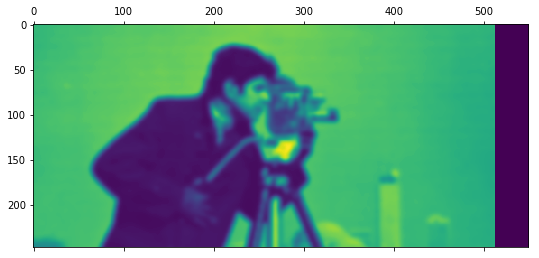

In [17]:
plt.matshow(mosaic_12[8])

In [18]:
mosaic_123 = ast2.stitch_zstack(images3, mosaic_12, 1, 0, 30, current_stack=None, out_path=None)

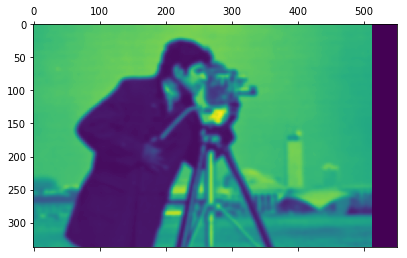

In [19]:
plt.matshow(mosaic_123[8])

### 2 channel case

#### First create z-stack that blurs with depth

In [5]:
#creates 10 images in z-stack, crisp to blurry with increasing n
intervals = np.linspace(0.0,3.0,num=10)
for z in range(1,11):
    for number in intervals:
        image = (skimage.filters.gaussian(camera, number)*255).astype('uint8')
        image_invert = (skimage.filters.gaussian(camera_invert, number)*255).astype('uint8')
        strip1 = image[50:200]
        strip2 = image[150:300]
        strip3 = image[250:400]
        strip1_invert = image_invert[50:200]
        strip2_invert = image_invert[150:300]
        strip3_invert = image_invert[250:400]
        strip1 = np.pad(strip1, ((0,0),(0,38)), 'constant', constant_values=(0))
        strip2 = np.pad(strip2, ((0,0),(38,0)), 'constant', constant_values=(0))
        strip3 = np.pad(strip3, ((0,0),(19,19)), 'constant', constant_values=(0))
        strip1_invert = np.pad(strip1_invert, ((0,0),(0,38)), 'constant', constant_values=(0))
        strip2_invert = np.pad(strip2_invert, ((0,0),(38,0)), 'constant', constant_values=(0))
        strip3_invert = np.pad(strip3_invert, ((0,0),(19,19)), 'constant', constant_values=(0)) 
        camera_2chan_strip1 = np.vstack((strip1, strip1_invert))
        camera_2chan_strip2 = np.vstack((strip2, strip2_invert))
        camera_2chan_strip3 = np.vstack((strip3, strip3_invert))
        z = int(number*3+1)
        tiff.imsave("camera_2chan_strip1_z%01d.tif" % z , camera_2chan_strip1)
        tiff.imsave("camera_2chan_strip2_z%01d.tif" % z , camera_2chan_strip2)
        tiff.imsave("camera_2chan_strip3_z%01d.tif" % z , camera_2chan_strip3)

In [5]:
images1= imread_collection("../notebooks/camera_2chan_strip1_z*")
images2= imread_collection("../notebooks/camera_2chan_strip2_z*")
images3= imread_collection("../notebooks/camera_2chan_strip3_z*")

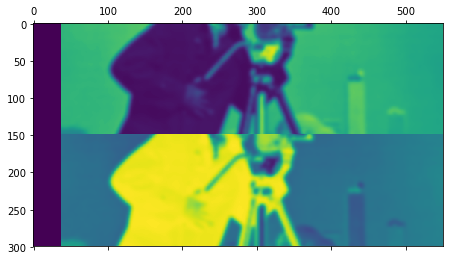

In [6]:
plt.matshow(images2[7])

In [7]:
mosaic_12 = ast2.stitch_zstack(images2, images1, 2, 0, 30, current_stack=None, out_path=None)

TypeError: slicing must be with an int or slice object

In [12]:
0*images1.shape[0]

AttributeError: 'ImageCollection' object has no attribute 'shape'

### Memmap case

In [33]:
#creates 10 images in z-stack, crisp to blurry with increasing n
intervals = np.linspace(0.0,3.0,num=10)
for z in range(1,11):
    for number in intervals:
        image = (skimage.filters.gaussian(camera, number)*255).astype('uint8')
        image_invert = (skimage.filters.gaussian(camera_invert, number)*255).astype('uint8')
        strip1 = image[50:200]
        strip2 = image[150:300]
        strip3 = image[250:400]
        strip1_invert = image_invert[50:200]
        strip2_invert = image_invert[150:300]
        strip3_invert = image_invert[250:400]
        strip1 = np.pad(strip1, ((0,0),(0,38)), 'constant', constant_values=(0))
        strip2 = np.pad(strip2, ((0,0),(38,0)), 'constant', constant_values=(0))
        strip3 = np.pad(strip3, ((0,0),(19,19)), 'constant', constant_values=(0))
        strip1_invert = np.pad(strip1_invert, ((0,0),(0,38)), 'constant', constant_values=(0))
        strip2_invert = np.pad(strip2_invert, ((0,0),(38,0)), 'constant', constant_values=(0))
        strip3_invert = np.pad(strip3_invert, ((0,0),(19,19)), 'constant', constant_values=(0)) 
        camera_2chan_strip1 = np.vstack((strip1, strip1_invert))
        camera_2chan_strip2 = np.vstack((strip2, strip2_invert))
        camera_2chan_strip3 = np.vstack((strip3, strip3_invert))
        z = int(number*3+1)
        tiff.imsave("camera_2chan_strip1_z%01d.tif" % z , camera_2chan_strip1)
        tiff.imsave("camera_2chan_strip2_z%01d.tif" % z , camera_2chan_strip2)
        tiff.imsave("camera_2chan_strip3_z%01d.tif" % z , camera_2chan_strip3)

In [34]:
images1= imread_collection("../notebooks/camera_2chan_strip1_z*")
images2= imread_collection("../notebooks/camera_2chan_strip2_z*")
images3= imread_collection("../notebooks/camera_2chan_strip3_z*")

In [40]:
from tempfile import mkdtemp
import os.path as path
def collection_to_memmap(collection):
    f = path.join(mkdtemp(), 'images7.dat')
    h = open(f, 'w')
    mm = np.memmap(f, dtype=collection[0].dtype, 
                   shape=(len(collection), 
                          collection[0].shape[0], 
                          collection[0].shape[1]))
    for z in range(mm.shape[0]):
        mm[z] = collection[z]
    
    return mm

In [43]:
images1 = collection_to_memmap(images1)
images2 = collection_to_memmap(images2)
images3 = collection_to_memmap(images3)

In [49]:
mosaic_12 = ast2.stitch_zstack(images2, images1, 2, 0, 30, current_stack=None, out_path=None)

TypeError: output_zstack() missing 1 required positional argument: 'chop_index'

In [45]:
debug

> /home/nicholasreder/alpenglow/alpenglow/stitching2.py(224)stitch_zstack()
    221                 registered[chan_index] = output_zstack(
    222                     images_1[chan_index*images_1.shape[0]//nchan:(chan_index+1)*images_1.shape[0]//nchan,:],
    223                     images_2[chan_index*images_2.shape[0]//nchan:(chan_index+1)*images_2.shape[0]//nchan,:],
--> 224                     coef, shift, chop_index, current_stack=current_stack, out_path=out_path)
    225             return registered

ipdb> u
> <ipython-input-44-6a674baeb3b5>(1)<module>()
----> 1 mosaic_12 = ast2.stitch_zstack(images2, images1, 2, 0, 30, current_stack=None, out_path=None)

ipdb> chop_index
*** NameError: name 'chop_index' is not defined
ipdb> q


### Pseudo-coloring algorithm

In [26]:
#constants
bkg_eosin=1000;
bkg_draq5=350;
k_eosin=0.011;
k_draq5=0.038;
voff1=10;
hoff1=-50;
beta1=0.860;
beta2=0.05;
beta3=1;
beta4=1;
beta5=0.300;
beta6=0.544;

In [28]:
camera_invert

array([[ 99,  98,  95, ..., 103, 103, 103],
       [ 99,  98,  96, ..., 103, 103, 103],
       [ 97,  98,  99, ..., 103, 103, 103],
       ..., 
       [134, 132, 129, ..., 134, 142, 144],
       [134, 132, 129, ..., 134, 142, 144],
       [134, 132, 129, ..., 134, 142, 144]], dtype=uint8)

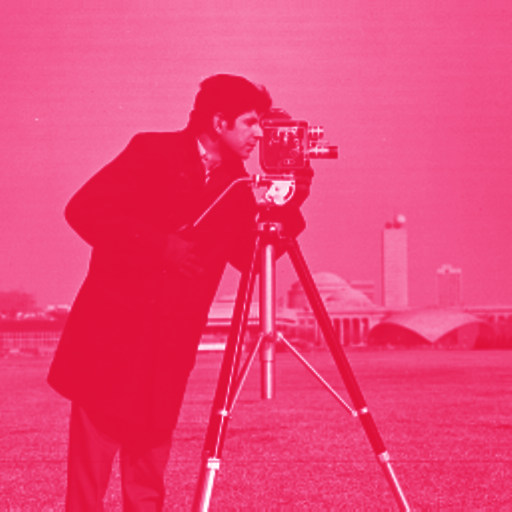

In [31]:
from PIL import Image
rgbArray = np.zeros((512,512,3), 'uint8')
rgbArray[..., 0] = np.exp(-beta2*camera_invert*k_eosin)*255
rgbArray[..., 1] = np.exp(-beta4*camera_invert*k_eosin)*255
rgbArray[..., 2] = np.exp(-beta6*camera_invert*k_eosin)*255
eosin = Image.fromarray(rgbArray)
eosin

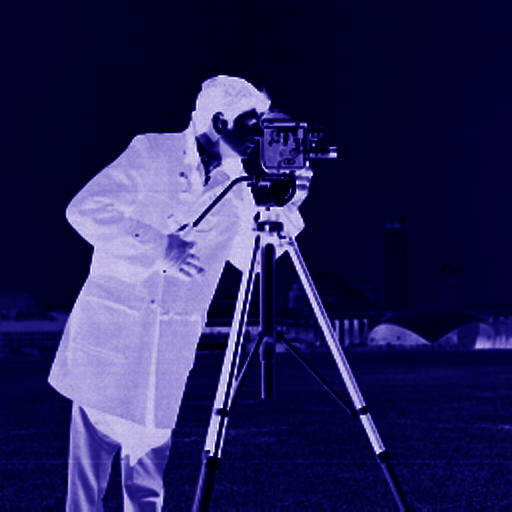

In [30]:
from PIL import Image
rgbArray = np.zeros((512,512,3), 'uint8')
rgbArray[..., 0] = np.exp(-beta1*camera*k_draq5)*255
rgbArray[..., 1] = np.exp(-beta3*camera*k_draq5)*255
rgbArray[..., 2] = np.exp(-beta5*camera*k_draq5)*255
draq5 = Image.fromarray(rgbArray)
draq5

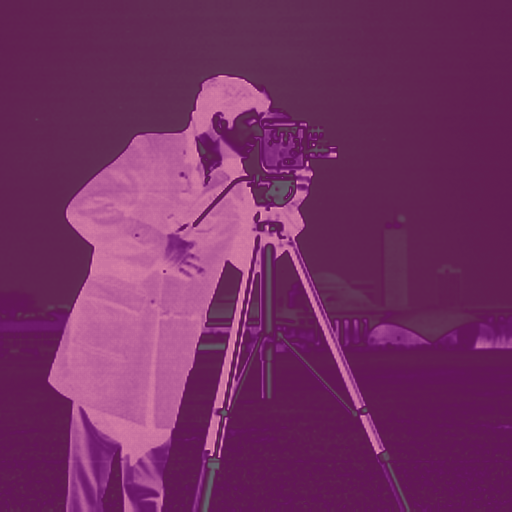

In [25]:
two_channel = Image.blend(eosin, draq5, 0.6)
two_channel